# Analyze H&E features with Kmeans clustering / For bone_marrow_s0

In [1]:
slide_id = "bone_marrow_s0"

**¡¡ RQ: cellvit features done for masks using nuclei segmentation, whereas phikonv2 and vit_google features done for masks using cells segmentation !!**

In [2]:
import os
import numpy as np
from tqdm import tqdm

import spatialdata as sd 
import anndata as ad
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator

## Cluster H&E features

In [3]:
adata_ini_cellvit = ad.read_h5ad(f"/Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/HE_features/features/adata_HEfeatures/{slide_id}/adata_features_{slide_id}_cellvit.h5ad")

# Filter cells with NA values for features
adata_cellvit = adata_ini_cellvit[np.isnan(adata_ini_cellvit.X).sum(axis=1) == 0].copy()
print(f"Number of cells with NA values removed: {adata_ini_cellvit.shape[0] - adata_cellvit.shape[0]}")
print(adata_cellvit)

Number of cells with NA values removed: 0
AnnData object with n_obs × n_vars = 225856 × 1280
    obs: 'cell_id', 'patch_ids'
    var: 'index'


In [4]:
adata_ini_phikonv2 = ad.read_h5ad(f"/Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/HE_features/features/adata_HEfeatures/{slide_id}/adata_features_{slide_id}_phikonv2.h5ad")

# Filter cells with NA values for features
adata_phikonv2 = adata_ini_phikonv2[np.isnan(adata_ini_phikonv2.X).sum(axis=1) == 0].copy()
print(f"Number of cells with NA values removed: {adata_ini_phikonv2.shape[0] - adata_phikonv2.shape[0]}")
print(adata_phikonv2)

Number of cells with NA values removed: 0
AnnData object with n_obs × n_vars = 225855 × 1024
    obs: 'cell_id', 'patch_ids'
    var: 'index'


In [5]:
adata_ini_vit_google = ad.read_h5ad(f"/Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/HE_features/features/adata_HEfeatures/{slide_id}/adata_features_{slide_id}_vit_google.h5ad")

# Filter cells with NA values for features
adata_vit_google = adata_ini_vit_google[np.isnan(adata_ini_vit_google.X).sum(axis=1) == 0].copy()
print(f"Number of cells with NA values removed: {adata_ini_vit_google.shape[0] - adata_vit_google.shape[0]}")
print(adata_vit_google)

Number of cells with NA values removed: 0
AnnData object with n_obs × n_vars = 225855 × 768
    obs: 'cell_id', 'patch_ids'
    var: 'index'


Finding optimal components: 100%|██████████| 3/3 [00:16<00:00,  5.44s/it]


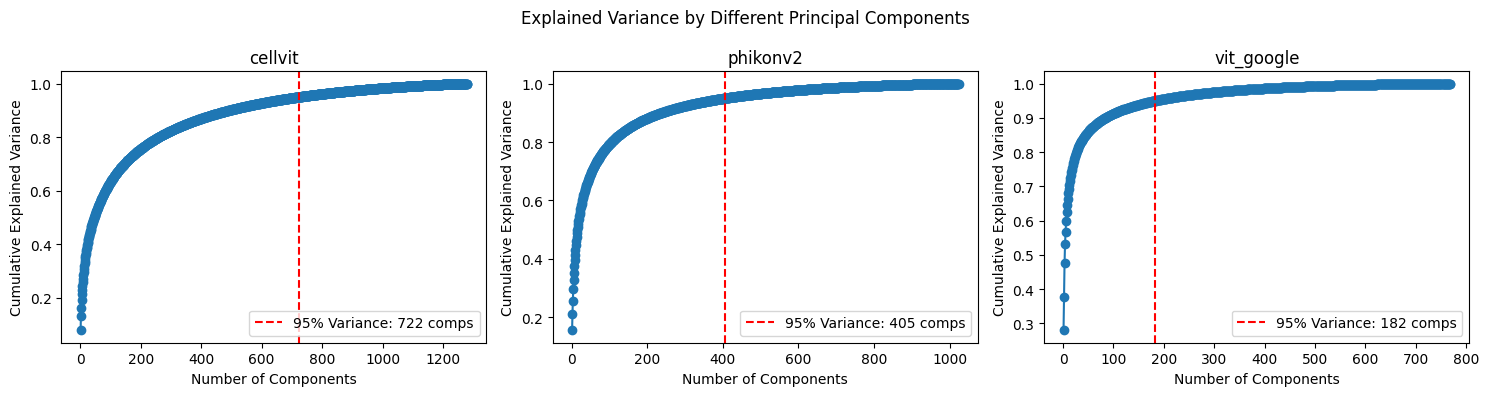

Model: cellvit, Optimal Components for 95% Variance: 722
Model: phikonv2, Optimal Components for 95% Variance: 405
Model: vit_google, Optimal Components for 95% Variance: 182


In [6]:
# Find the best number of components for each model

datasets = {"cellvit": adata_cellvit, "phikonv2": adata_phikonv2, "vit_google": adata_vit_google}
scaled_features_all = {"cellvit": [], "phikonv2": [], "vit_google": []}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

optimal_components = {}

for ax, model_name in tqdm(zip(axes, datasets.keys()), total=len(datasets), desc="Finding optimal components"):
    
    # Ensure X is of type float32
    datasets[model_name].X = datasets[model_name].X.astype('float32')

    # Scale features to unit variance
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(datasets[model_name].X)
    scaled_features_all[model_name] = scaled_features

    # Fit PCA on scaled data
    pca = PCA().fit(scaled_features)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Find the number of components explaining 95% variance
    n_components = np.argmax(cumulative_variance >= 0.95) + 1
    optimal_components[model_name] = n_components

    # Plotting the Cumulative Summation of the Explained Variance
    ax.plot(range(1, len(pca.explained_variance_ratio_) + 1), cumulative_variance, marker='o')
    ax.axvline(n_components, linestyle='--', color='r', label=f'95% Variance: {n_components} comps')
    ax.set_xlabel('Number of Components')
    ax.set_ylabel('Cumulative Explained Variance')
    ax.set_title(model_name)
    ax.legend()

plt.suptitle('Explained Variance by Different Principal Components')
plt.tight_layout()
plt.show()

# Print optimal number of components
for model_name, n_components in optimal_components.items():
    print(f"Model: {model_name}, Optimal Components for 95% Variance: {n_components}")

In [7]:
# Choose best number of components for each model
n_components = optimal_components # {"cellvit": tochoose, "phikonv2": tochoose, "vit_google": tochoose}

In [8]:
# Applying PCA with the optimal number of components
pca_results = {"cellvit": [], "phikonv2": [], "vit_google": []}
for model_name in tqdm(datasets.keys(), desc="Applying PCA"):
    pca = PCA(n_components=n_components[model_name], random_state=42)
    pca_result = pca.fit_transform(scaled_features_all[model_name]) # The pca_result is an array with the transformed features
    pca_results[model_name] = pca_result

Applying PCA: 100%|██████████| 3/3 [00:29<00:00,  9.73s/it]


Finding optimal clusters for vit_google: 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


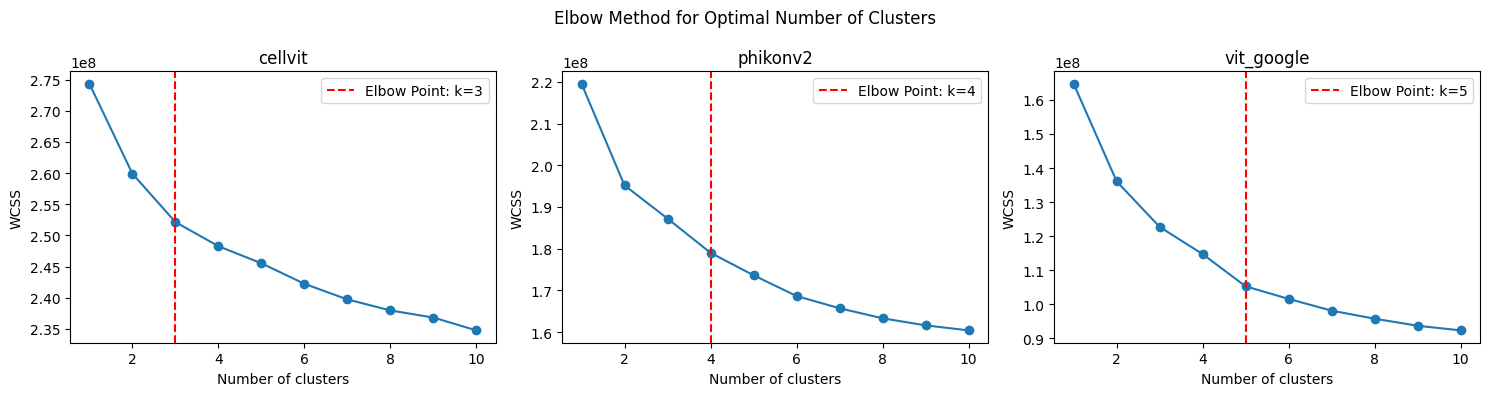

Optimal number of clusters for cellvit: 3
Optimal number of clusters for phikonv2: 4
Optimal number of clusters for vit_google: 5


In [9]:
# Find the optimal number of clusters using the Elbow Method

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
optimal_clusters = {}

for ax, model_name in zip(axes, datasets.keys()):
    wcss = []
    for k in tqdm(range(1, 11), desc=f"Finding optimal clusters for {model_name}"):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(pca_results[model_name])
        wcss.append(kmeans.inertia_)

    # Use KneeLocator to find the elbow point
    kl = KneeLocator(range(1, 11), wcss, curve="convex", direction="decreasing")
    elbow = kl.knee
    optimal_clusters[model_name] = elbow

    # Plot the WCSS curve and mark the elbow point
    ax.plot(range(1, 11), wcss, marker='o')
    ax.axvline(elbow, linestyle='--', color='r', label=f'Elbow Point: k={elbow}')
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('WCSS')
    ax.set_title(model_name)
    ax.legend()

plt.suptitle('Elbow Method for Optimal Number of Clusters')
plt.tight_layout()
plt.show()

# Print the optimal number of clusters for each model
for model_name, elbow in optimal_clusters.items():
    print(f"Optimal number of clusters for {model_name}: {elbow}")

In [10]:
# Choose the optimal number of clusters for each model
n_clusters = optimal_clusters # {"cellvit": tochoose, "phikonv2": tochoose, "vit_google": tochoose}

Processing models: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


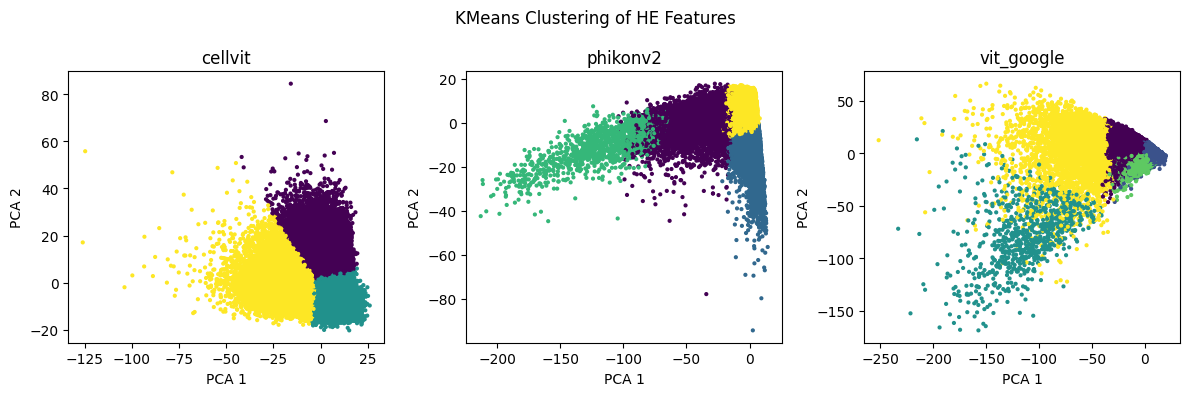

In [11]:
# Apply KMeans clustering with the optimal number of clusters

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, model_name in tqdm(zip(axes, datasets.keys()), total=len(datasets), desc='Processing models'):

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters[model_name], random_state=42)
    cluster_labels = kmeans.fit_predict(pca_results[model_name])
    datasets[model_name].obs[f"kmeans_clusterHE_{model_name}"] = cluster_labels.astype(str) # adding the cluster labels to the adata
    datasets[model_name].obsm[f"X_pca_{model_name}"] = pca_results[model_name] # adding also pca results in the adata

    # Plot the clusters
    ax.scatter(pca_results[model_name][:, 0], pca_results[model_name][:, 1], c=cluster_labels, cmap='viridis', s=4)
    ax.set_title(model_name)
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')

plt.suptitle('KMeans Clustering of HE Features')
plt.tight_layout()
plt.show()

## Compare H&E clusters with clusters using RNA information

In [12]:
sdata = sd.read_zarr(f"/Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_{slide_id}.zarr", selection=('tables',))
sdata

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_boundaries', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'nucleus_boundaries', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_bone_marrow_s0.zarr
└── Tables
      ├── 'table_cells': AnnData (225906, 477)
      ├── 'table_combined': AnnData (225906, 541)
      ├── 'table_nuclei': AnnData (225906, 541)
      └── 'table_scvi': AnnData (225906, 477)
with coordinate systems:

with the following elements in the Zarr store but not in the SpatialData object:
    ▸ nucleus_boundaries (Shapes)
    ▸ he (Images)
    ▸ morpho (Images)
    ▸ st (Points)
    ▸ cell_boundaries (Shapes)
    ▸ he_patches (Shapes)

In [13]:
sdata.tables['table_cells']

AnnData object with n_obs × n_vars = 225906 × 477
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'pca_n10_pcs16_leiden_res0.2', 'pca_n10_pcs16_leiden_res0.4', 'pca_n10_pcs16_leiden_res0.6', 'refine_res', 'label1', 'label2', 'label3', 'transcript_cat', 'transcript_counts_log', 'PanNuke_label', 'PanNuke_proba', 'final_label'
    var: 'gene_ids', 'feature_types', 'genome', 'mean', 'std'
    uns: 'final_label_colors', 'label1_colors', 'label2_colors', 'label3_colors', 'pca', 'pca_n10_pcs16', 'pca_n10_pcs16_leiden_res0.2', 'pca_n10_pcs16_leiden_res0.2_colors', 'pca_n10_pcs16_leiden_res0.4', 'pca_n10_pcs16_leiden_res0.4_colors', 'pca_n10_pcs16_leiden_res0.6', 'pca_n10_pcs16_leiden_res0.6_colors', 'rank_genes_refine_res', 'refine_res_colors', 'spatialdata_attrs', 'transcript_cat_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
  

In [14]:
def HE_on_RNA(sdata, datasets, neighbors_key_cells):
    
    for model in datasets.keys():

        # Add the adata_features to sdata
        sdata.tables[f"features_{model}"] = datasets[model].copy()
        
        # Add the features cluster to table_cells, table_nuclei and table_combined
        id2cluster = dict(datasets[model].obs[['cell_id', f'kmeans_clusterHE_{model}']].values)
        for table_name in ['table_cells']:
            sdata.tables[table_name].obs[f'kmeans_clustersHE_{model}'] = sdata.tables[table_name].obs['cell_id'].map(id2cluster).fillna('-1').astype('category')
    
    print("For table_cells:")
    sc.pl.umap(sdata.tables['table_cells'][(sdata.tables['table_cells'].obs["transcript_counts"]>10)],
               neighbors_key=neighbors_key_cells,
               color=['label1', 'final_label', 'kmeans_clustersHE_cellvit', 'kmeans_clustersHE_phikonv2', 'kmeans_clustersHE_vit_google'],
               ncols=3)

For table_cells:


/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


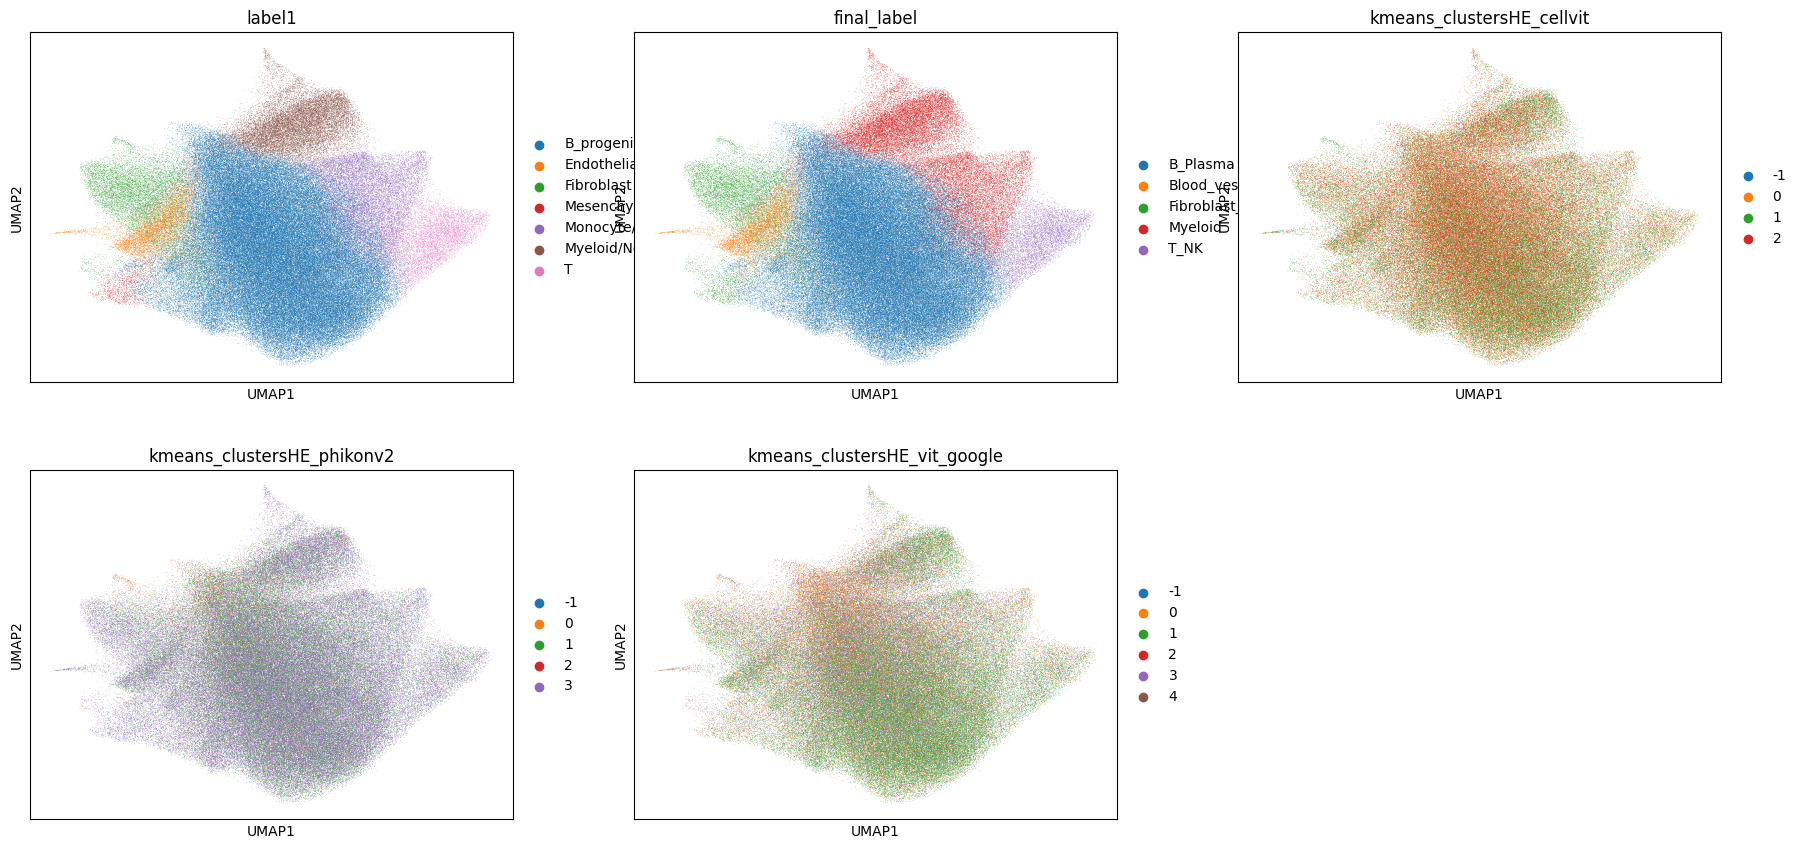

In [15]:
HE_on_RNA(sdata, datasets, neighbors_key_cells='pca_n10_pcs16')

In [16]:
# Write features tables on disk
for model in datasets.keys():
    #sdata.delete_element_from_disk(f"features_{model}")
    sdata.write_element(f"features_{model}")

In [17]:
# Write table_cells, table_nuclei and table_combined on disk
for table_name in ['table_cells']:
    sdata.delete_element_from_disk(table_name)
    sdata.write_element(table_name)